# Analisis de cliente

## Problema (caso de estudio)

### Resumen

**Descripcion de los datos**:  

+ **customer :** `ID del cliente`                        
+ **state :** `estados en US`                      
+ **customer_lifetime_value :** `CLV es el valor economico del cliente para la empresa durante toda su relacion`
+ **response :**  `Respuesta a campañas/llamadas (marketing-engagement)`                   
+ **coverage :** `Tipo de cobertura del cliente`                        
+ **education** `Nivel educativo del cliente`                   
+ **effective_to_date :** `Fecha efectiva`              
+ **employmentstatus :** `Estado laboral del cliente`                
+ **gender :**  `Genero del cliente`                  
+ **income :**  `Ingresos del cliente`
+ **location_code :** `Zona de residencia del cliente`                  
+ **marital_status :** `Estado Civil del cliente`                  
+ **monthly_premium_auto :** `Premium mensual`            
+ **months_since_last_claim :** `Ultima reclamacion del cliente`          
+ **months_since_policy_inception :** `Inicio de la poliza`    
+ **number_of_open_complaints :** `Reclamaciones abiertas`        
+ **number_of_policies :** `Numero de polizas`              
+ **policy_type :** `Tipo de poliza`                     
+ **policy :** `Poliza`                         
+ **renew_offer_type :**  `Oferta de renovacion`                 
+ **sales_channel :**  `Canal de ventas (primer contacto compañia-cliente)`                 
+ **total_claim_amount :** `Monto de la reclamacion`              
+ **vehicle_class :**  `Tipo de vehiculo`                 
+ **vehicle_size :**  `Tamaño del vehiculo`  


**Objetivo:**

Mejorar el CLV a traves del marketing.

In [2]:
import warnings
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pandas as pd
pd.set_option('display.max_columns', None)

## Obtener datos

In [4]:
data=pd.read_csv('../datasets/Marketing-Customer-Analysis.csv')

data.columns=[e.lower().replace(' ', '_') for e in data.columns]

data.head()

,customer,state,customer_lifetime_value,response,coverage,education,effective_to_date,employmentstatus,gender,income,location_code,marital_status,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies,policy_type,policy,renew_offer_type,sales_channel,total_claim_amount,vehicle_class,vehicle_size
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2/24/11,Employed,F,56274,Suburban,Married,69,32,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,1/31/11,Unemployed,F,0,Suburban,Single,94,13,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,AI49188,Nevada,12887.431650,No,Premium,Bachelor,2/19/11,Employed,F,48767,Suburban,Married,108,18,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
3,WW63253,California,7645.861827,No,Basic,Bachelor,1/20/11,Unemployed,M,0,Suburban,Married,106,18,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
4,HB64268,Washington,2813.692575,No,Basic,Bachelor,2/3/11,Employed,M,43836,Rural,Single,73,12,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize


## Analisis exploratorio

#### Objetivo

In [5]:
data.customer_lifetime_value.describe()

count     9134.000000
mean      8004.940475
std       6870.967608
min       1898.007675
25%       3994.251794
50%       5780.182197
75%       8962.167041
max      83325.381190
Name: customer_lifetime_value, dtype: float64

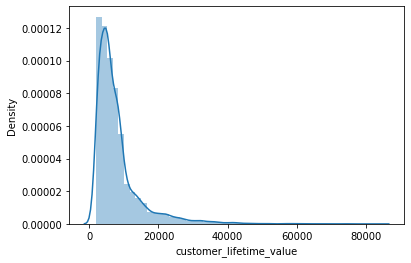

In [6]:
sns.distplot(data.customer_lifetime_value);

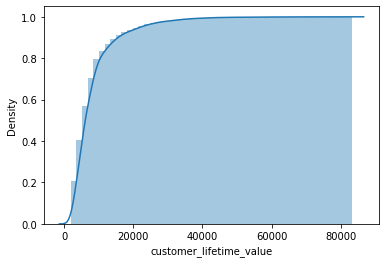

In [10]:
sns.distplot(data.customer_lifetime_value,
            hist_kws={'cumulative':True},
            kde_kws={'cumulative':True});

#### a) Numero total de clientes que responden a las campañas de marketing (engagement)

In [14]:
data.groupby('response').count().customer

response
No     7826
Yes    1308
Name: customer, dtype: int64

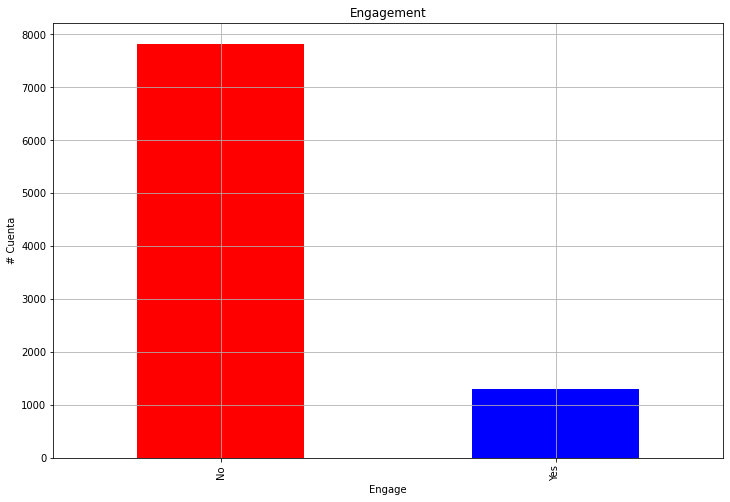

In [15]:
ax=data.groupby('response').count().customer.plot(
    kind='bar',
    color=['r', 'b'],
    grid=True,
    figsize=(12, 8),
    title='Engagement'
)

ax.set_xlabel('Engage')
ax.set_ylabel('# Cuenta')

plt.show();

In [16]:
data.groupby('response').count().customer/data.shape[0]

response
No     0.856799
Yes    0.143201
Name: customer, dtype: float64

**Esto nos muestra que solo el 14% de los clientes responden positivamente a las campañas.**

#### b) Oferta de renovacion

Nos fijaremos en los datos de las ofertas de renovacion. Buscaremos que tipo de oferta funciona mejor para los clientes.

In [18]:
por_tipo_de_oferta=data.loc[data.response=='Yes']\
                       .groupby(['renew_offer_type'])\
                       .count().customer/data.groupby('renew_offer_type').count().customer

por_tipo_de_oferta

renew_offer_type
Offer1    0.158316
Offer2    0.233766
Offer3    0.020950
Offer4         NaN
Name: customer, dtype: float64

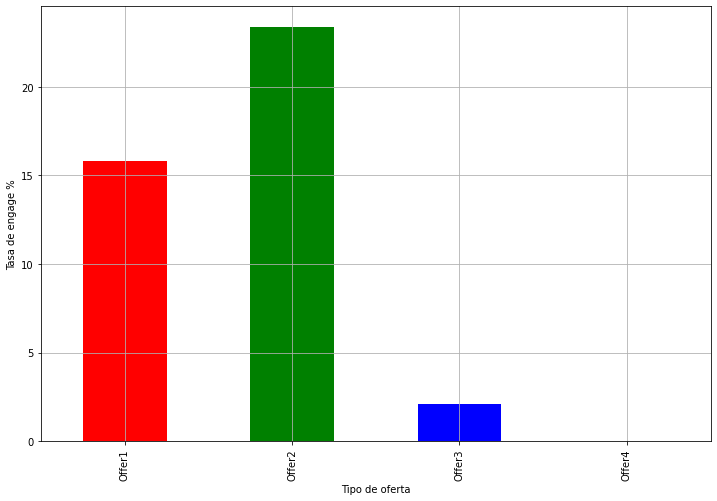

In [19]:
ax=(por_tipo_de_oferta*100).plot(kind='bar', figsize=(12, 8), 
                                 color=['r', 'g', 'b', 'y'], grid=True)

ax.set_xlabel('Tipo de oferta')
ax.set_ylabel('Tasa de engage %')

plt.show();

**Podemos ver que la oferta tipo 2 tiene mayor engage.**

#### c) Renovacion/Atributo

Ahora vamos a intentar entender como los clientes con diferentes atributos responden a los mensajes de marketing.
Empezaremos observando la respuesta para cada tipo de oferta y clase de vehiculo.

In [20]:
def engage(res, group1, group2):
    
    df=data.loc[data.response==res]\
                    .groupby([group1, group2])\
                    .count().customer/data.groupby(group1).count().customer
    
    df=df.unstack().fillna(0)
    
    ax=(df*100).plot(kind='bar', figsize=(12, 8), grid=True)
    ax.set_ylabel('Tasa de engage %')

    plt.show();
    
    return df

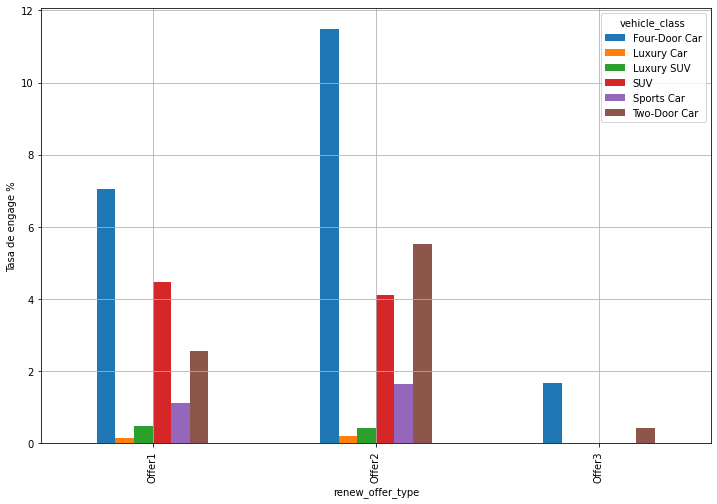

vehicle_class,Four-Door Car,Luxury Car,Luxury SUV,SUV,Sports Car,Two-Door Car
renew_offer_type,,,,,,
Offer1,0.070362,0.001599,0.004797,0.044776,0.011194,0.025586
Offer2,0.114833,0.002051,0.004101,0.041012,0.016405,0.055366
Offer3,0.016760,0.000000,0.000000,0.000000,0.000000,0.004190


In [21]:
engage('Yes', 'renew_offer_type', 'vehicle_class')

**Ya sabiamos que el tipo 2 de oferta tenia la respuesta mas alta entre los clientes, aunque ahora se pueden ver mas cosas cruzando con otros atributos, por ejemplo, la clase vehiculo. Los clientes con vehiculos de 4 puertas responden con mayor frecuencia a todo tipo de ofertas, y aquellos clientes con Luxury SUV responden con mas alta frecuecia las ofertas tipo 1 y 2. Si tenemos diferencias significativas entre las tasas de respuesta entre los clientes, podemos ajustar el objetivo de las distintas ofertas.**

In [22]:
data.columns

Index(['customer', 'state', 'customer_lifetime_value', 'response', 'coverage',
       'education', 'effective_to_date', 'employmentstatus', 'gender',
       'income', 'location_code', 'marital_status', 'monthly_premium_auto',
       'months_since_last_claim', 'months_since_policy_inception',
       'number_of_open_complaints', 'number_of_policies', 'policy_type',
       'policy', 'renew_offer_type', 'sales_channel', 'total_claim_amount',
       'vehicle_class', 'vehicle_size'],
      dtype='object')

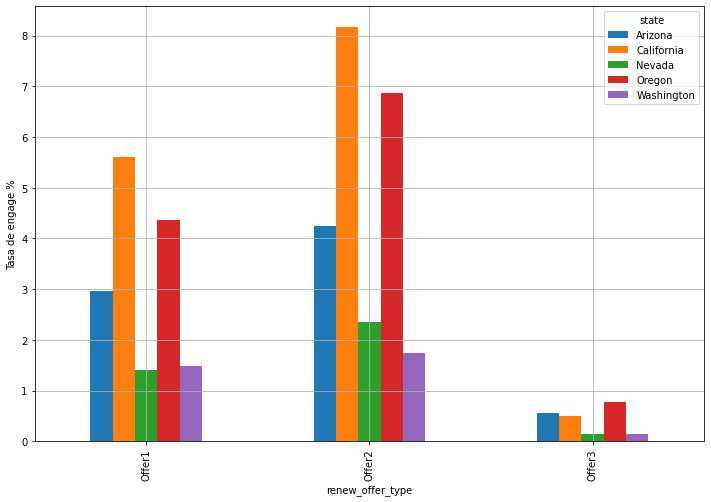

state,Arizona,California,Nevada,Oregon,Washington
renew_offer_type,,,,,
Offer1,0.029584,0.055970,0.014126,0.043710,0.014925
Offer2,0.042379,0.081681,0.023582,0.068694,0.017430
Offer3,0.005587,0.004888,0.001397,0.007682,0.001397


In [23]:
engage('Yes', 'renew_offer_type', 'state')

#### d) Analizando la tasas de respuesta por genero

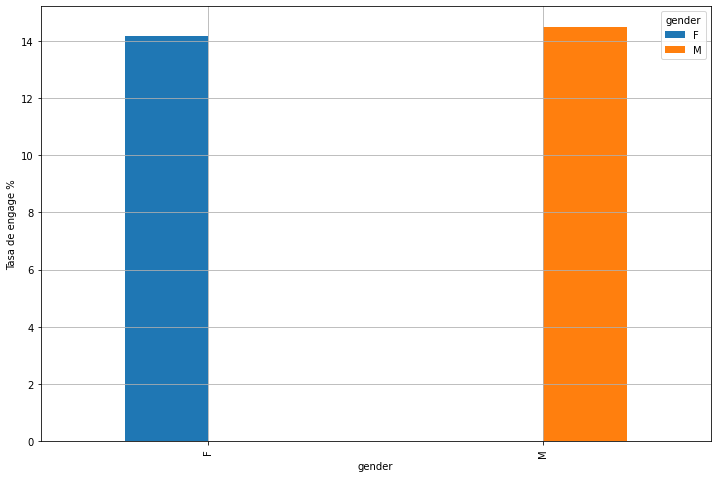

gender,F,M
gender,,
F,0.141692,0.000000
M,0.000000,0.144772


In [30]:
engage('Yes', 'gender', 'gender')

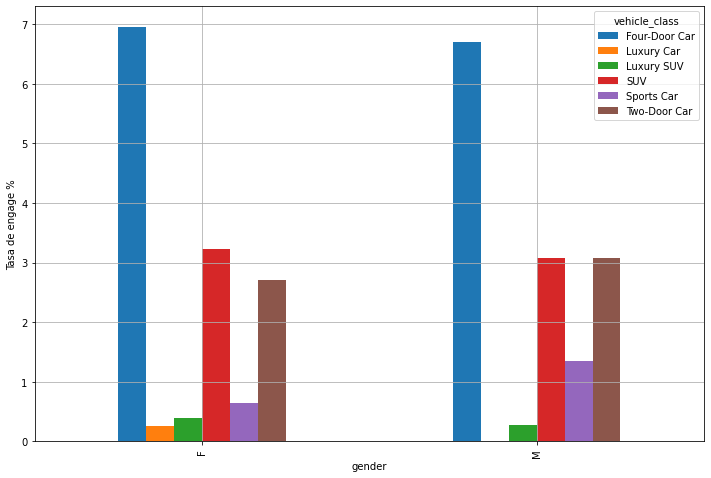

vehicle_class,Four-Door Car,Luxury Car,Luxury SUV,SUV,Sports Car,Two-Door Car
gender,,,,,,
F,0.069558,0.002576,0.003864,0.032203,0.006441,0.027050
M,0.067024,0.000000,0.002681,0.030831,0.013405,0.030831


In [31]:
engage('Yes', 'gender', 'vehicle_class')

**Las clases estan balanceadas. Pero se puede observar una menor respuesta entre las mujeres. Por otro lado, los hombres con coches de lujo no responden nunca a las campañs de marketing.**

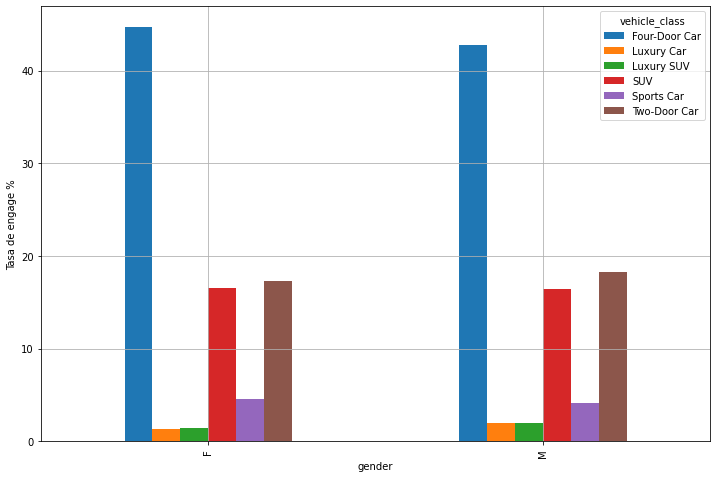

vehicle_class,Four-Door Car,Luxury Car,Luxury SUV,SUV,Sports Car,Two-Door Car
gender,,,,,,
F,0.446973,0.013525,0.013954,0.165736,0.045513,0.172606
M,0.427837,0.019660,0.019884,0.164433,0.040661,0.182752


In [34]:
engage('No', 'gender', 'vehicle_class')

#### e) Analizando la tasa de respuesta por diferentes canales de venta

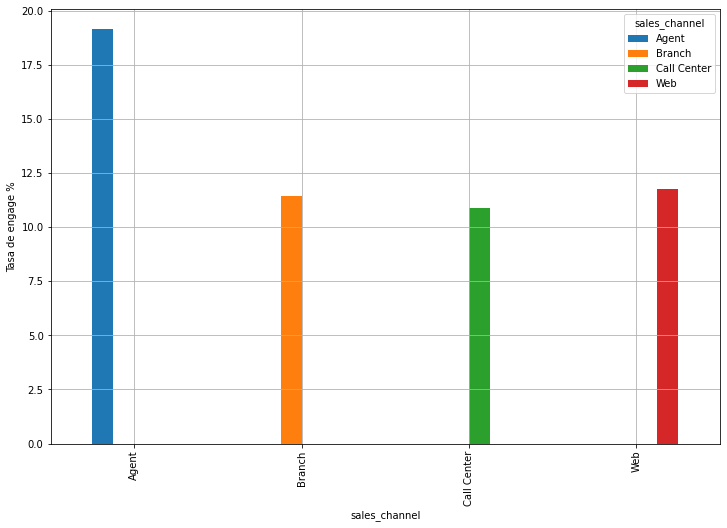

sales_channel,Agent,Branch,Call Center,Web
sales_channel,,,,
Agent,0.191544,0.000000,0.000000,0.000000
Branch,0.000000,0.114531,0.000000,0.000000
Call Center,0.000000,0.000000,0.108782,0.000000
Web,0.000000,0.000000,0.000000,0.117736


In [32]:
engage('Yes', 'sales_channel', 'sales_channel')

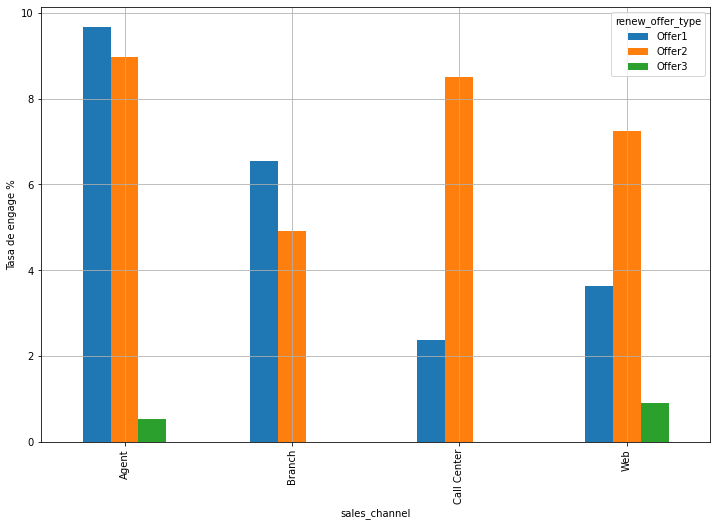

renew_offer_type,Offer1,Offer2,Offer3
sales_channel,,,
Agent,0.096635,0.089733,0.005177
Branch,0.065446,0.049085,0.000000
Call Center,0.023796,0.084986,0.000000
Web,0.036226,0.072453,0.009057


In [33]:
engage('Yes', 'sales_channel', 'renew_offer_type')

**Como podemos ver, Agent funciona mejor en terminos de obtener respuesta de los clientes, y en segundo lugar Web. Podemos ver otras relaciones.**

**La oferta tipo 3 no funciona en el canal Branch ni en el canal Call Center. La oferta tipo 1 necesita mejorar Call Centers.**

#### e) Clusterizacion Sencilla

Vamos a segmentar a los clientes segun el CLV y segun los meses desde el inicio de la poliza.

Aquellos clientes con un CLV mayor que la mediana, se clasifican como alto CLV (`high`), aquellos por debajo de la mediana como bajo CLV (`low`).

In [35]:
data['clv_segment']=data.customer_lifetime_value\
                        .apply(lambda x: 'high' if x>data.customer_lifetime_value.median() else 'low')


In [38]:
data.months_since_policy_inception.describe()

count    9134.000000
mean       48.064594
std        27.905991
min         0.000000
25%        24.000000
50%        48.000000
75%        71.000000
max        99.000000
Name: months_since_policy_inception, dtype: float64

In [39]:
data['policy_age_segment']=data.months_since_policy_inception\
                               .apply(lambda x: 'high' if x>data.months_since_policy_inception.median() else 'low')


In [40]:
data.head()

,customer,state,customer_lifetime_value,response,coverage,education,effective_to_date,employmentstatus,gender,income,location_code,marital_status,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies,policy_type,policy,renew_offer_type,sales_channel,total_claim_amount,vehicle_class,vehicle_size,clv_segment,policy_age_segment
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2/24/11,Employed,F,56274,Suburban,Married,69,32,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize,low,low
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,1/31/11,Unemployed,F,0,Suburban,Single,94,13,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize,high,low
2,AI49188,Nevada,12887.431650,No,Premium,Bachelor,2/19/11,Employed,F,48767,Suburban,Married,108,18,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize,high,low
3,WW63253,California,7645.861827,No,Basic,Bachelor,1/20/11,Unemployed,M,0,Suburban,Married,106,18,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize,high,high
4,HB64268,Washington,2813.692575,No,Basic,Bachelor,2/3/11,Employed,M,43836,Rural,Single,73,12,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize,low,low


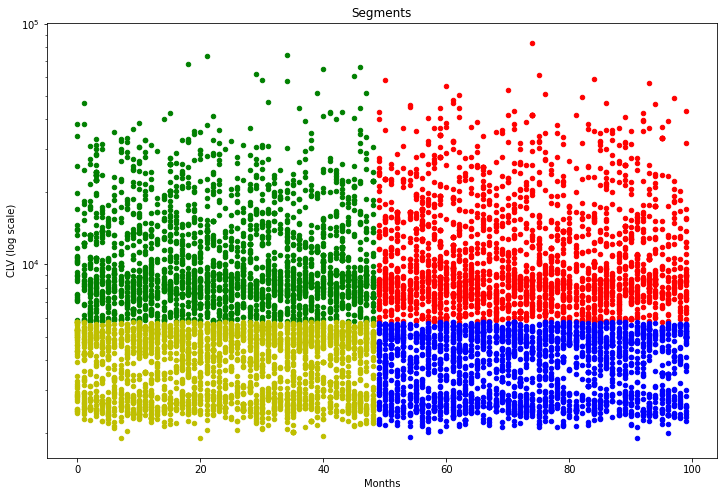

In [60]:
ax=data.loc[(data.clv_segment=='high')&(data.policy_age_segment=='high')]\
       .plot.scatter(x='months_since_policy_inception', y='customer_lifetime_value',
                    logy=True, color='r', figsize=(12, 8))

data.loc[(data.clv_segment=='low')&(data.policy_age_segment=='high')]\
       .plot.scatter(ax=ax, 
                     x='months_since_policy_inception', y='customer_lifetime_value',
                     logy=True, color='b')

data.loc[(data.clv_segment=='high')&(data.policy_age_segment=='low')]\
       .plot.scatter(ax=ax,
                     x='months_since_policy_inception', y='customer_lifetime_value',
                     logy=True, color='g')

data.loc[(data.clv_segment=='low')&(data.policy_age_segment=='low')]\
       .plot.scatter(ax=ax,
                     x='months_since_policy_inception', y='customer_lifetime_value',
                     logy=True, color='y')



#ax.set_ylim(1e3, 3*1e5)
#ax.set_xlim(0, 60)
ax.set_ylabel('CLV (log scale)')
ax.set_xlabel('Months')
ax.set_title('Segments')
plt.show();

`logy=True` transforma la escala una escala logaritmica, que se usa a menudo en valores monetario, aunque suelen generar un problema de simetria (skewness). 

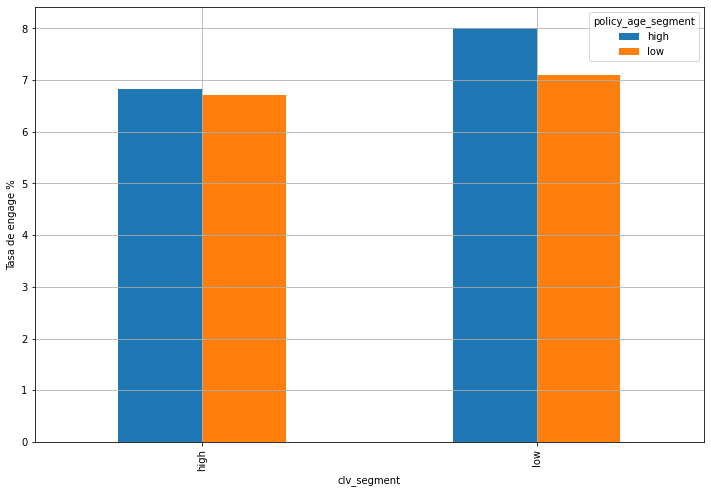

policy_age_segment,high,low
clv_segment,,
high,0.068331,0.067017
low,0.080123,0.070928


In [52]:
engage('Yes', 'clv_segment', 'policy_age_segment')

**Podemos ver que el segmento de polizas mas antiguas tiene mayor tasa de respuesta. Esto sugiere que esos clientes que llevan mas tiempo en la compañia responden mejor. De hecho, el mejor segmento de los cuatro en respuesta es el de polizas mas antiguas y bajo CLV. Creando diferentes segmentaciones de los clientes basandonos en sus atributos, podemos tener un mejor entendimiento del comportamiento de los distintos tipos de clientes y, por tanto, desarrollar una mejor estrategia de marketing.**

### Conclusion


+ Objetivo:
    + **Mejorar el CLV** (Media CLV: 8005)
    
+ Insights:
    + Solo el 14% de los clientes responden a campañas de marketing (Mejorar respuesta)
    + La oferta tipo 2 tiene la mayor tasa de respuesta (¿Cual es la diferencia entre las ofertas?)
    + Los clientes con Luxury SUV responden con mayor frecuencia a las ofertas 1 y 2
    + Principalmente enfocado en coches de cuatro puertas 
    + La oferta tipo 3 no es representativa (cambiarla y/o eliminarla, enfoque en coches deportivos y de lujo. Lo mismo con la oferta 4)
    + Las mujeres tienen menor tasa de respuesta 
    + Los hombres con coches de lujo no responden en absoluto
    + La oferta tipo 3 no funciona en los canales de venta branch y call center 
    + La oferta tipo 1 necesita mejorar en call centers 
    + Los clientes mas antiguos responden mejor 